## Baseline classification results for catinous

In [1]:
from pytorch_lightning import Trainer
#from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
import catinous.CatsinomModelGramCache as catsmodel
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve, accuracy_score
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
from py_jotools import mut, cache
import SimpleITK as sitk

import catinous.utils as catutils


%load_ext autoreload
%autoreload 2

In [151]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

# Loading test sets

In [6]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='test', res='lr'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='test', res='hr'), batch_size=8, num_workers=4)
test_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='test', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

## Testing LR model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_lr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


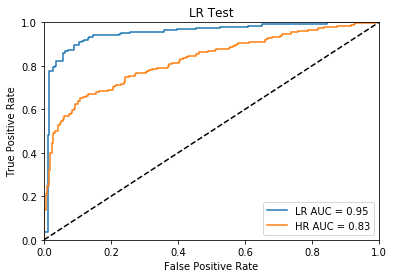

In [26]:
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR')

## Testing LR-base model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_lr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


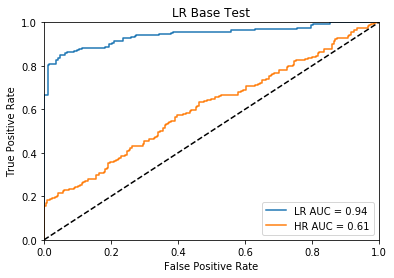

In [27]:
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR Base')

## Testing HR Model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


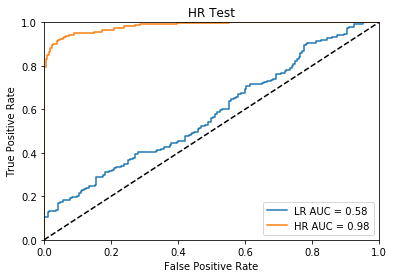

In [28]:
hparams={'continous':False,
         'datasetfile': 'catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR')

## Testing HR-base model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': 'catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


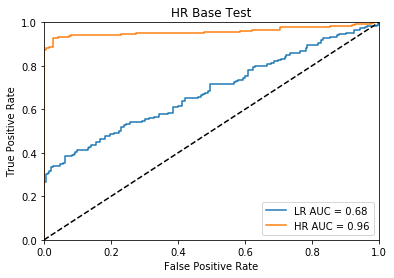

In [29]:
hparams={'continous':False,
         'datasetfile': 'catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR Base')

## Testing combined model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_combined_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


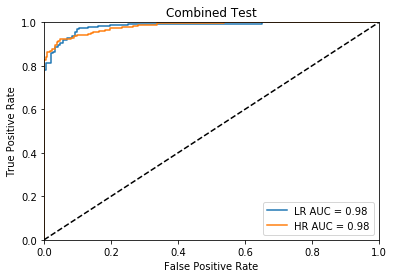

In [24]:
hparams={'continous':False,
         'datasetfile': 'catsinom_combined_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='Combined')

## Testing LR-HR

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': 'batch_lr_train-base_train_1_013cced594.pt',
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


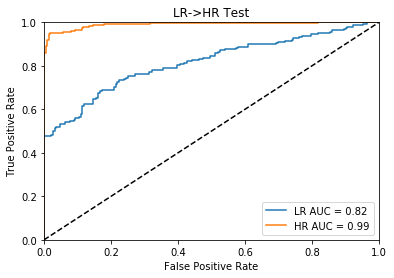

In [25]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000,
        'base_model': 'batch_lr_train-base_train_1_013cced594.pt'}

model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR->HR')

## Testing HR-LR

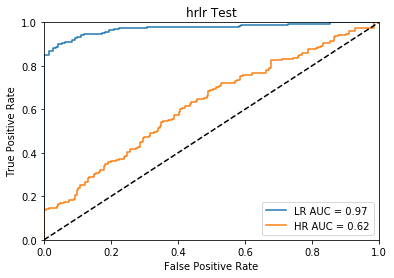

In [5]:
plot_test_roc('hrlr', {'LR': test_lr, 'HR': test_hr}, device)

# Continous training random cache

In [5]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

def test_metrices(hparams, datasets, device):
    roc_aucs = dict()
    accuracies = dict()
    fprs = dict()
    tprs = dict()
    
    for i in range(1, 6):
        hparams['run_postfix'] = i
        model, logs, df_cache, modelpath = catsmodel.trained_model(hparams)
        model = model.to(device) #not sure why this is needed, model should be on device
        model.freeze()
        
        for ds in datasets:
            target, output = test_model(model, datasets[ds], device)
    
            #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        
            output_bin = [int(o>0.5) for o in output]
                        
            fpr, tpr, _ = roc_curve(target, output)
            
            if i==1:
                roc_aucs[ds] = list()
                fprs[ds] = list()
                tprs[ds] = list()
                accuracies[ds] = list()
                
            roc_aucs[ds].append(auc(fpr, tpr))
            accuracies[ds].append(accuracy_score(target, output_bin))
            fprs[ds].append(fpr)
            tprs[ds].append(tpr)
            
    return (roc_aucs, accuracies, fprs, tprs)

In [226]:
val_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='val', res='lr'), batch_size=8, num_workers=4)
val_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='val', res='hr'), batch_size=8, num_workers=4)
val_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts2_dataset.csv', split='val', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [7]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}

roc_aucs, accuracies, fprs, tprs = test_metrices(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts}, device)

INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt


In [220]:
print('LR', np.array(roc_aucs['LR']).mean(), np.array(roc_aucs['LR']).std())
print('HR', np.array(roc_aucs['HR']).mean(), np.array(roc_aucs['HR']).std())
print('HR TS', np.array(roc_aucs['HR TS']).mean(), np.array(roc_aucs['HR TS']).std())

LR 0.9048831569664904 0.034291930314649346
HR 0.894866394629459 0.015766274087477106
HR TS 0.945335919590901 0.06122438046275573


In [8]:
print('LR', np.array(roc_aucs['LR']).mean(), np.array(roc_aucs['LR']).std())
print('HR', np.array(roc_aucs['HR']).mean(), np.array(roc_aucs['HR']).std())
print('HR TS', np.array(roc_aucs['HR TS']).mean(), np.array(roc_aucs['HR TS']).std())

LR 0.9132330246913579 0.025484740633677377
HR 0.9075863279364661 0.022277761788615433
HR TS 0.870278610474343 0.07916546183201013


In [ ]:
print('LR', np.array(accuracies_val['LR']).mean(), np.array(accuracies_val['LR']).std())
print('HR', np.array(accuracies_val['HR']).mean(), np.array(accuracies_val['HR']).std())
print('HR TS', np.array(accuracies_val['HR TS']).mean(), np.array(accuracies_val['HR TS']).std())

# continous without cache

In [223]:
print('LR', np.array(roc_aucs_wo_cache['LR']).mean(), np.array(roc_aucs_wo_cache['LR']).std())
print('HR', np.array(roc_aucs_wo_cache['HR']).mean(), np.array(roc_aucs_wo_cache['HR']).std())
print('HR TS', np.array(roc_aucs_wo_cache['HR TS']).mean(), np.array(roc_aucs_wo_cache['HR TS']).std())

LR 0.606630291005291 0.01774751777702316
HR 0.8950024132332939 0.013386021191131013
HR TS 0.9972932463410332 0.0005877233552899827


# Result Figures

In [3]:
df_wo_cache = None
for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_wo_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_wo_cache is None:
        df_wo_cache = df_temp
    else:
        df_wo_cache = df_wo_cache.append(df_temp)
        
        
df_randomcache = None

for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_random_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_randomcache is None:
        df_randomcache = df_temp
    else:
        df_randomcache = df_randomcache.append(df_temp)


In [4]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'lr'

In [5]:
newcmp = ListedColormap([sns.color_palette()[1], sns.color_palette()[0]], name='OrangeBlue')

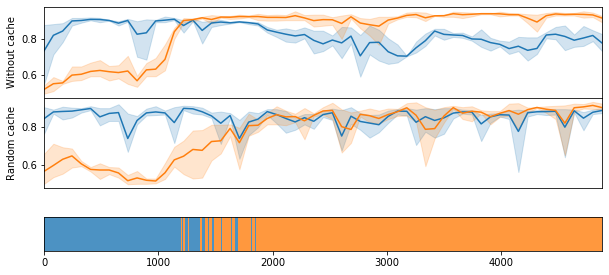

In [6]:
fig, ax = plt.subplots(3,1, figsize=(10, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0])
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0])
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 60)
ax[0].set_ylabel('Without cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 60)
ax[1].set_ylabel('Random cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()

# Analyze Cache

In [8]:
def plot_cache_imgs(df, num_images=None):
    imgs = []
    for i, fp in enumerate(df.filepath):
        simg = sitk.ReadImage(os.path.join('/project/catinous/cat_data', fp))
        img = sitk.GetArrayFromImage(simg)

        img = mut.intensity_window(img, low=-1024, high=400)
        img = mut.norm01(img)
        imgs.append(img[0])
        if num_images is not None:
            if num_images>i:
                break

    mut.mimshow(np.asarray(imgs), nslic=len(df))

In [196]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_fmiss_cache_tf07_5_cb1ec7caee.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr,2,2,2
hr_ts,40,40,40
lr,22,22,22


In [198]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr_ts,14,14,14
lr,50,50,50


In [199]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_fmiss_cache_tf07_5_227917df84.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr_ts,14,14,14
lr,50,50,50


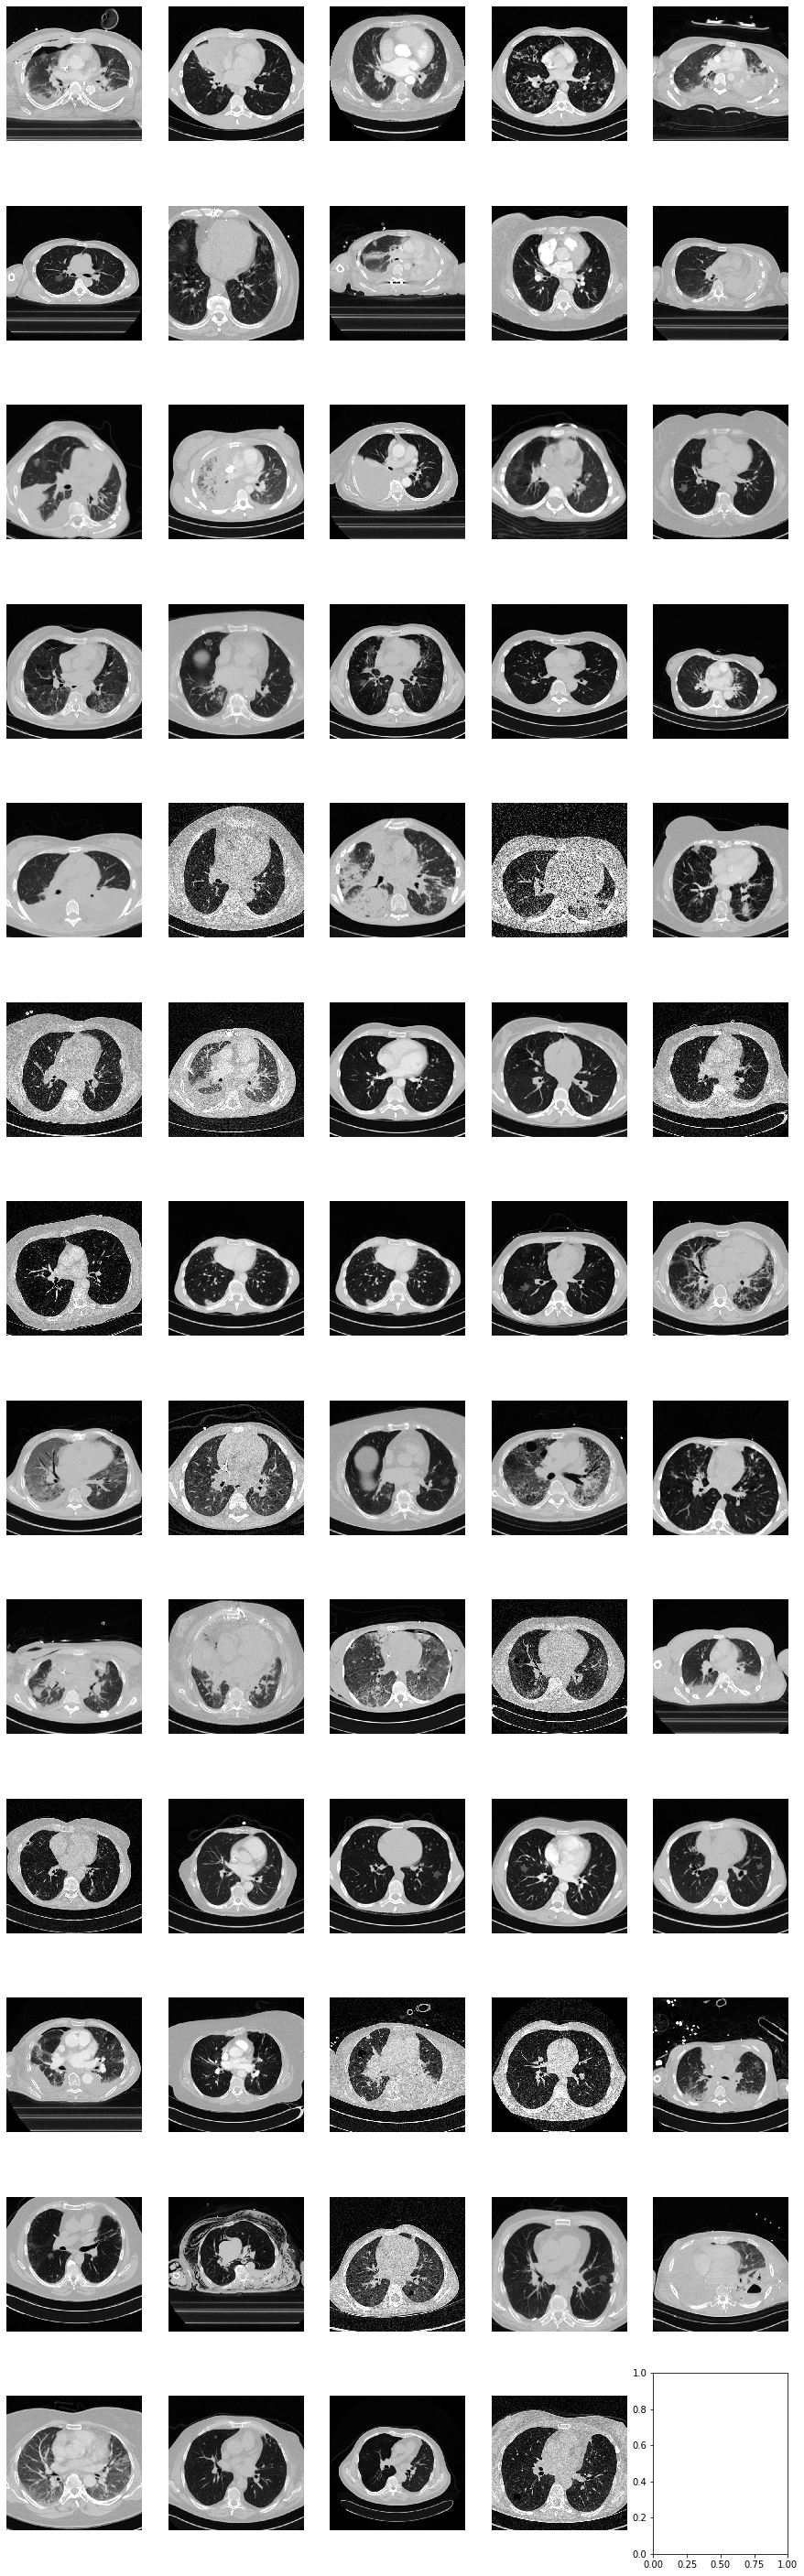

In [152]:
plot_cache_imgs(df_cache)

In [6]:
df_test = pd.read_csv('catsinom_combined_dsts2_dataset.csv', index_col=0)
df_test['filepath'] = '/project/catinous/cat_data/' + df_test['image']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [11]:
df_test = df_test.sample(frac=1.0)

In [ ]:
plot_cache_imgs(df_test, num_images=8)

In [28]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dsts3_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = pd.factorize(streamedDS.df.res)[0]

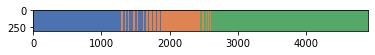

In [29]:
plt.imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=1.0)

In [17]:
if ('lr' in res) and ('hr' in res):
    print(res)
    exp_name = utils.get_expname(self.hparams)
    weights_path = utils.TRAINED_MODELS_FOLDER + exp_name + '_lr_checkpoint.pt'
    if not os.path.exists(weights_path):
        torch.save(self.model.state_dict(), weights_path)
elif ('hr' in res) and ('hr_ts'):
    print(res)
    exp_name = utils.get_expname(self.hparams)
    weights_path = utils.TRAINED_MODELS_FOLDER + exp_name + '_hr_checkpoint.pt'
    if not os.path.exists(weights_path):
        torch.save(self.model.state_dict(), weights_path)

(array([0, 0, 0, ..., 2, 2, 2]), Index(['lr', 'hr', 'hr_ts'], dtype='object'))

In [34]:
streamedDS.df.res

0          lr
1          lr
2          lr
3          lr
4          lr
        ...  
4439    hr_ts
4440    hr_ts
4441    hr_ts
4442    hr_ts
4443    hr_ts
Name: res, Length: 4444, dtype: category
Categories (3, object): [hr, hr_ts, lr]

In [3]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not catsmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)    
        else:
            _, df_temp, _, _ = catsmodel.trained_model(base_params[-1])
            df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

In [77]:
data = 'catsinom_combined_dsts_dataset.csv'
# data = 'catsinom_combined_dataset.csv'


# df_randomcache = pd.DataFrame()
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}
df_randomcache = res_data_for_params(hparams)
              
# df_wo_cache = pd.DataFrame()
hparams={'continous': True,
         'use_cache':False,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30}
df_wo_cache = res_data_for_params(hparams)

INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_d932962d94.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_90c7c94bce.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_f6ef5fb3df.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_c38cac9bb6.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_d2b2d48020.pt


NameError: name 'res' is not defined

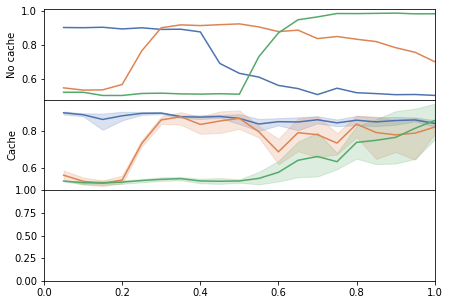

In [78]:

newcmp = ListedColormap(sns.color_palette("deep", 3))
sns.set_palette(sns.color_palette("deep", 3))

fig, ax = plt.subplots(3,1, figsize=(7, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_wo_cache, y='val_acc_hr_ts', x='idx', ax=ax[0], err_style=None)
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 20)
ax[0].set_ylabel('No cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr_ts', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 20)
ax[1].set_ylabel('Cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=1.0)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()

NameError: name 'res' is not defined

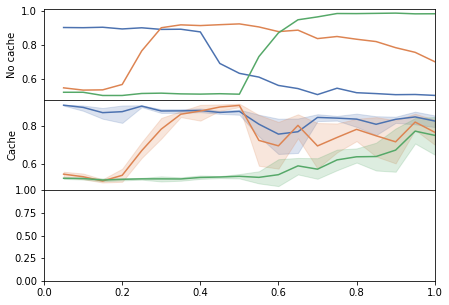

In [4]:
newcmp = ListedColormap(sns.color_palette("deep", 3))
sns.set_palette(sns.color_palette("deep", 3))

fig, ax = plt.subplots(3,1, figsize=(7, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0], err_style=None)
sns.lineplot(data=df_wo_cache, y='val_acc_hr_ts', x='idx', ax=ax[0], err_style=None)
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 20)
ax[0].set_ylabel('No cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr_ts', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 20)
ax[1].set_ylabel('Cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=1.0)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()

In [30]:
df_randomcache

,created_at,epoch,train_loss,val_acc_hr,val_acc_hr_ts,val_acc_lr,val_loss_hr,val_loss_hr_ts,val_loss_lr,idx
3,2020-03-02 15:41:25.505511,0,NaN,0.561321,0.528302,0.907895,1.317430,1.541144,0.280642,1
7,2020-03-02 15:44:50.424287,0,NaN,0.563679,0.530660,0.905263,1.337508,1.601058,0.275831,2
11,2020-03-02 15:48:13.848190,0,NaN,0.497642,0.511792,0.865790,1.642573,1.639874,0.319093,3
15,2020-03-02 15:51:37.643343,0,NaN,0.500000,0.511792,0.757895,1.537078,1.472958,0.430242,4
19,2020-03-02 15:55:01.681082,0,NaN,0.632075,0.530660,0.907895,0.695128,0.911080,0.273884,5
...,...,...,...,...,...,...,...,...,...,...
63,2020-03-02 17:41:25.320463,0,NaN,0.747642,0.636792,0.855263,0.524762,0.602720,0.386291,16
67,2020-03-02 17:44:48.426624,0,NaN,0.820755,0.761792,0.868421,0.482863,0.531749,0.349751,17
71,2020-03-02 17:48:12.256679,0,NaN,0.839623,0.808962,0.842105,0.468118,0.498480,0.437478,18
75,2020-03-02 17:51:36.234780,0,NaN,0.834906,0.856132,0.881579,0.416784,0.413004,0.371550,19


In [230]:
res = ['LR', 'LR', 'LR']
res2 = ['LR', 'LR', 'HR']

In [233]:
np.unique(res2)

array(['HR', 'LR'], dtype='<U2')

In [236]:
if 'HR' in res:
    print('lr')

# BWT/FWT/Accuracies

In [183]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='test', res='lr'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='test', res='hr'), batch_size=8, num_workers=4)
test_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='test', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [182]:
val_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='val', res='lr'), batch_size=8, num_workers=4)
val_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='val', res='hr'), batch_size=8, num_workers=4)
val_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='val', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [307]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def test_metrices(hparams, datasets, device, suffix='.pt'):
    roc_aucs = dict()
    accuracies = dict()
    
    for i in range(1, 6):
        hparams['run_postfix'] = i
        model = catsmodel.CatsinomModelGramCache(hparams=hparams, device=device)
        exp_name = catutils.get_expname(model.hparams)
        weights_path = catutils.TRAINED_MODELS_FOLDER + exp_name + suffix
        if os.path.exists(weights_path):
            if suffix == '.pt': #HACK hack hack
                print('loading', weights_path)
                model.load_state_dict(torch.load(weights_path))
            else:
                model.model.load_state_dict(torch.load(weights_path))
            model.to(device)
            model.freeze()
        
            for ds in datasets:
                target, output = test_model(model, datasets[ds], device)

                #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')

                output_bin = [int(o>0.5) for o in output]
                fpr, tpr, _ = roc_curve(target, output)

                if i==1:
                    roc_aucs[ds] = list()
                    accuracies[ds] = list()
                    
                roc_aucs[ds].append(auc(fpr, tpr))
                accuracies[ds].append(accuracy_score(target, output_bin))
        else:
            print('model checkpoint doesnt exist', weights_path)
            
    return (roc_aucs, accuracies)

def get_rocs_accuracies_bwts_fwts(hparams, datasets):
    roc_aucs_lr, accuracies_lr = test_metrices(hparams, datasets, device, suffix='_lr_checkpoint.pt')
    roc_aucs_hr, accuracies_hr = test_metrices(hparams, datasets, device, suffix='_hr_checkpoint.pt')
    roc_aucs_end, accuracies_end = test_metrices(hparams, datasets, device, suffix='.pt')


    bwts=[]
    fwts=[]
    for i in range(len(accuracies_lr['LR'])):
        R = np.array([[accuracies_lr['LR'][i], accuracies_lr['HR'][i], accuracies_lr['HR TS'][i]],
                  [accuracies_hr['LR'][i], accuracies_hr['HR'][i], accuracies_hr['HR TS'][i]],
                  [accuracies_end['LR'][i], accuracies_end['HR'][i], accuracies_end['HR TS'][i]]])

        bwts.append(((R[2][0] - R[0][0]) + (R[2][1] - R[1][1]))/2)
        fwts.append((R[0][1]-0.5 + R[1][2]-0.5)/2)
        
    return roc_aucs_lr, roc_aucs_hr, roc_aucs_end, accuracies_lr, accuracies_hr, accuracies_end, bwts, fwts

In [192]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}

(roc_aucs_val, accuracies_val) = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

print('LR', np.array(accuracies_val['LR']).mean(), np.array(accuracies_val['LR']).std())
print('HR', np.array(accuracies_val['HR']).mean(), np.array(accuracies_val['HR']).std())
print('HR TS', np.array(accuracies_val['HR TS']).mean(), np.array(accuracies_val['HR TS']).std())
print('mean', np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).mean(), np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).std())

INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt
LR 0.8530503978779841 0.018192496763376385
HR 0.8089622641509433 0.05235636575664758
HR TS 0.8716981132075473 0.0957976946027765
mean 0.8445702584121584 0.06910165649582849


In [217]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':32,
            'force_misclassified':True}

(roc_aucs_val, accuracies_val) = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

print('LR', np.array(accuracies_val['LR']).mean(), np.array(accuracies_val['LR']).std())
print('HR', np.array(accuracies_val['HR']).mean(), np.array(accuracies_val['HR']).std())
print('HR TS', np.array(accuracies_val['HR TS']).mean(), np.array(accuracies_val['HR TS']).std())
print('mean', np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).mean(), np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).std())

INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6.pt
LR 0.8175066312997347 0.032024166096098816
HR 0.8556603773584905 0.022690591454350387
HR TS 0.9273584905660378 0.04898398107829119
mean 0.8668418330747544 0.05819820580570941


In [221]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr_ts,12,12,12
lr,20,20,20


In [193]:
hparams={'continous': True,
         'force_misclassified': True,
         'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
         'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
         'val_check_interval': 30,
         'cachemaximum': 64,
         'gram_weights': [0, 0, 0, 1]}

(roc_aucs_val, accuracies_val) = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

print('LR', np.array(accuracies_val['LR']).mean(), np.array(accuracies_val['LR']).std())
print('HR', np.array(accuracies_val['HR']).mean(), np.array(accuracies_val['HR']).std())
print('HR TS', np.array(accuracies_val['HR TS']).mean(), np.array(accuracies_val['HR TS']).std())
print('mean', np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).mean(), np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).std())

INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_9487e80066.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_9487e80066.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_665d699cbd.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_665d699cbd.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_e806423581.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_e806423581.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_f9a9c338c0.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_f9a9c338c0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_cb1ec7caee.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_cb1ec7caee.pt
LR 0.7989389920424405 0.0466240266158511
HR 0.8561320754716981 0.020936170774690722
HR TS 0.9462264150943396 0.029283298481450466
mean 0.8670991608694926 0.06951460904576025


In [210]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_fmiss_cache_tf07_3_e806423581.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr,3,3,3
hr_ts,33,33,33
lr,28,28,28


In [191]:
hparams={'continous': True,
         'force_misclassified': True,
         'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
         'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
         'val_check_interval': 30,
         'cachemaximum': 64,
         'gram_weights': [1, 0, 0, 0]}

(roc_aucs_val, accuracies_val) = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

print('LR', np.array(accuracies_val['LR']).mean(), np.array(accuracies_val['LR']).std())
print('HR', np.array(accuracies_val['HR']).mean(), np.array(accuracies_val['HR']).std())
print('HR TS', np.array(accuracies_val['HR TS']).mean(), np.array(accuracies_val['HR TS']).std())
print('mean', np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).mean(), np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).std())

INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_3ecc5cfcc9.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_3ecc5cfcc9.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_cf23984c37.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_cf23984c37.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_58bcdacb61.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_58bcdacb61.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_e0b13de9b0.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_e0b13de9b0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_227917df84.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_227917df84.pt
LR 0.8763925729442971 0.0061866863605785525
HR 0.8009433962264151 0.057338005279331125
HR TS 0.8070754716981131 0.10971823844572336
mean 0.828137146956275 0.07932148545821383


In [201]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_basemodel_lr_fmiss_cache_tf07_5_227917df84.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr_ts,14,14,14
lr,50,50,50


In [296]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':32,
            'force_misclassified':True}

(auc_lr_cache, auc_hr_cache, auc_end_cache, acc_lr_cache, acc_hr_cache, acc_end_cache, bwts_cache, fwts_cache)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts})
#print('ewc, cont', 'bwt', np.array(bwts).mean(), np.array(bwts).std(), 'fwt', np.array(fwts).mean(), np.array(fwts).std())
#print('roc auc', 'lr', np.array(roc_aucs_end['LR']).mean(), np.array(roc_aucs_end['LR']).std(), 'hr', np.array(roc_aucs_end['HR']).mean(),  np.array(roc_aucs_end['HR']).std(), 'hr ts', np.array(roc_aucs_end['HR TS']).mean(), np.array(roc_aucs_end['HR TS']).std())

INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6.pt


In [173]:
print('cache, cont', 'bwt', np.array(bwts_cache).mean(), np.array(bwts_cache).std(), 'fwt', np.array(fwts_cache).mean(), np.array(fwts_cache).std())
print('roc auc', 'lr', np.array(auc_end_cache['LR']).mean(), np.array(auc_end_cache['LR']).std(), 'hr', np.array(auc_end_cache['HR']).mean(),  np.array(auc_end_cache['HR']).std(), 'hr ts', np.array(auc_end_cache['HR TS']).mean(), np.array(auc_end_cache['HR TS']).std())
print('accuracies', 'lr', np.array(acc_end_cache['LR']).mean(), np.array(acc_end_cache['LR']).std(), 'hr', np.array(acc_end_cache['HR']).mean(),  np.array(acc_end_cache['HR']).std(), 'hr ts', np.array(acc_end_cache['HR TS']).mean(), np.array(acc_end_cache['HR TS']).std())

cache, cont bwt -0.07109418699711714 0.008690447801056881 fwt 0.05566019065210938 0.024659232782867708
roc auc lr 0.9010582010582011 0.01905572663742 hr 0.8892282041156598 0.005570498744896964 hr ts 0.9427481925586317 0.04029488192231233
accuracies lr 0.851968503937008 0.014622979818566018 hr 0.8037470725995316 0.05056379099603972 hr ts 0.8676056338028169 0.09050932120980175


In [297]:
print('cache, cont', 'bwt', np.array(bwts_cache).mean(), np.array(bwts_cache).std(), 'fwt', np.array(fwts_cache).mean(), np.array(fwts_cache).std())
print('roc auc', 'lr', np.array(auc_end_cache['LR']).mean(), np.array(auc_end_cache['LR']).std(), 'hr', np.array(auc_end_cache['HR']).mean(),  np.array(auc_end_cache['HR']).std(), 'hr ts', np.array(auc_end_cache['HR TS']).mean(), np.array(auc_end_cache['HR TS']).std())
print('accuracies', 'lr', np.array(acc_end_cache['LR']).mean(), np.array(acc_end_cache['LR']).std(), 'hr', np.array(acc_end_cache['HR']).mean(),  np.array(acc_end_cache['HR']).std(), 'hr ts', np.array(acc_end_cache['HR TS']).mean(), np.array(acc_end_cache['HR TS']).std())

cache, cont bwt -0.07319085114360704 0.023070038908490218 fwt 0.0669058064232389 0.011850205780053458
roc auc lr 0.8730820105820106 0.020296504213145484 hr 0.8998552060023692 0.02053887151219603 hr ts 0.9639746076529713 0.03254095549087746
accuracies lr 0.8125984251968503 0.026173125170221325 hr 0.8463700234192038 0.019571505775902717 hr ts 0.9234741784037558 0.042890349654671346


In [314]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':80,
            'force_misclassified':True}

(auc_lr_cache, auc_hr_cache, auc_end_cache, acc_lr_cache, acc_hr_cache, acc_end_cache, bwts_cache, fwts_cache)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts})
print('cache, cont', 'bwt', np.array(bwts_cache).mean(), np.array(bwts_cache).std(), 'fwt', np.array(fwts_cache).mean(), np.array(fwts_cache).std())
print('roc auc', 'lr', np.array(auc_end_cache['LR']).mean(), np.array(auc_end_cache['LR']).std(), 'hr', np.array(auc_end_cache['HR']).mean(),  np.array(auc_end_cache['HR']).std(), 'hr ts', np.array(auc_end_cache['HR TS']).mean(), np.array(auc_end_cache['HR TS']).std())
print('accuracies', 'lr', np.array(acc_end_cache['LR']).mean(), np.array(acc_end_cache['LR']).std(), 'hr', np.array(acc_end_cache['HR']).mean(),  np.array(acc_end_cache['HR']).std(), 'hr ts', np.array(acc_end_cache['HR TS']).mean(), np.array(acc_end_cache['HR TS']).std())

INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80
INFO:root:Gram hooks and cache initialized. Cachesize: 80


loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_5a29113f81.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 80


loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_70a0287e95.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 80


loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_203bed1faa.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 80


loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_0eba2ba63c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 80


loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_0b4279d711.pt
cache, cont bwt -0.05104648804145382 0.023416241928566516 fwt 0.050509065320887093 0.018149922459381723
roc auc lr 0.9026014109347443 0.004739365412560866 hr 0.8860142161379493 0.014517574920786364 hr ts 0.9214071592311763 0.0789707014134332
accuracies lr 0.857742782152231 0.008689210161284443 hr 0.8252927400468384 0.03230152627553475 hr ts 0.8727699530516432 0.09969646896610505


In [50]:
hparams={'continous': True,
             'use_cache':False,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30}

(auc_lr_nocache, auc_hr_nocache, auc_end_nocache, acc_lr_nocache, acc_hr_nocache, acc_end_nocache, bwts_nocache, fwts_nocache)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts})

/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_d932962d94_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_90c7c94bce_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_f6ef5fb3df_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_c38cac9bb6_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_d2b2d48020_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_d932962d94_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_90c7c94bce_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_f6ef5fb3df_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_c38cac9bb6_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_

In [51]:
print('no cache, cont', 'bwt', np.array(bwts_nocache).mean(), np.array(bwts_nocache).std(), 'fwt', np.array(fwts_nocache).mean(), np.array(fwts_nocache).std())
print('roc auc', 'lr', np.array(auc_end_nocache['LR']).mean(), np.array(auc_end_nocache['LR']).std(), 'hr', np.array(auc_end_nocache['HR']).mean(),  np.array(auc_end_nocache['HR']).std(), 'hr ts', np.array(auc_end_nocache['HR TS']).mean(), np.array(auc_end_nocache['HR TS']).std())
print('accuracies', 'lr', np.array(acc_end_nocache['LR']).mean(), np.array(acc_end_nocache['LR']).std(), 'hr', np.array(acc_end_nocache['HR']).mean(),  np.array(acc_end_nocache['HR']).std(), 'hr ts', np.array(acc_end_nocache['HR TS']).mean(), np.array(acc_end_nocache['HR TS']).std())

no cache, cont bwt -0.3162926355517036 0.008501777556067527 fwt 0.046035227760002614 0.0004683840749414526
roc auc lr 0.5976410934744267 0.02624826425040445 hr 0.8839541924443859 0.006491087075800733 hr ts 0.9973461470640099 0.0005305845526072148
accuracies lr 0.5065616797900262 0.001659988273054276 hr 0.7063231850117095 0.015717060173829074 hr ts 0.9751173708920188 0.0070578856236492475


In [52]:
hparams={'continous': True,
         'use_cache': False,
         'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
         'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
         'EWC': True,
         'EWC_dataset': 'catsinom_lr_dataset.csv',
         'EWC_lambda': 1000,
         'EWC_bn_off': True,
         'val_check_interval': 30}

(auc_lr_ewcfbn, auc_hr_ewcfbn, auc_end_ewcfbn, acc_lr_ewcfbn, acc_hr_ewcfbn, acc_end_ewcfbn, bwts_ewcfbn, fwts_ewcfbn)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts})

/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_3da5bb481c_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_a80f14b403_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_0374cb1c0d_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_897ae95d55_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_a6c1c8413a_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_3da5bb481c_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_a80f14b403_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_0374cb1c0d_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_897ae95d55_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_

In [57]:
print('ewc fbn, cont', 'bwt', np.array(bwts_ewcfbn).mean(), np.array(bwts_ewcfbn).std(), 'fwt', np.array(fwts_ewcfbn).mean(), np.array(bwts_ewcfbn).std())
print('roc auc', 'lr', np.array(auc_end_ewcfbn['LR']).mean(), np.array(auc_end_ewcfbn['LR']).std(), 'hr', np.array(auc_end_ewcfbn['HR']).mean(),  np.array(auc_end_ewcfbn['HR']).std(), 'hr ts', np.array(auc_end_ewcfbn['HR TS']).mean(), np.array(auc_end_ewcfbn['HR TS']).std())
print('accuracies', 'lr', np.array(acc_end_ewcfbn['LR']).mean(), np.array(acc_end_ewcfbn['LR']).std(), 'hr', np.array(acc_end_ewcfbn['HR']).mean(),  np.array(acc_end_ewcfbn['HR']).std(), 'hr ts', np.array(acc_end_ewcfbn['HR TS']).mean(), np.array(acc_end_ewcfbn['HR TS']).std())

ewc fbn, cont bwt -0.0807685924505338 0.019470691398272604 fwt 0.06388220030565908 0.019470691398272604
roc auc lr 0.9649994488536155 0.007540139800046603 hr 0.8299153174498706 0.043657031589464504 hr ts 0.9870922235937225 0.0015687068950812366
accuracies lr 0.8887139107611548 0.02368611899775008 hr 0.7372365339578454 0.05245901639344263 hr ts 0.9413145539906104 0.04358871131806631


In [54]:
hparams={'continous': True,
         'use_cache': False,
         'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
         'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
         'EWC': True,
         'EWC_dataset': 'catsinom_lr_dataset.csv',
         'EWC_lambda': 1000,
         'EWC_bn_off': False,
         'val_check_interval': 30}

(auc_lr_ewc, auc_hr_ewc, auc_end_ewc, acc_lr_ewc, acc_hr_ewc, acc_end_ewc, bwts_ewc, fwts_ewc)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts})

/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_96b99f59c6_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_167c6c54d3_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_e879a113e5_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_207321ff99_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_52d2ad2673_lr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_96b99f59c6_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_167c6c54d3_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_e879a113e5_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_207321ff99_hr_checkpoint.pt
/project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_

In [58]:
print('ewc, cont', 'bwt', np.array(bwts_ewc).mean(), np.array(bwts_ewc).std(), 'fwt', np.array(fwts_ewc).mean(), np.array(fwts_ewc).std())
print('roc auc', 'lr', np.array(auc_end_ewc['LR']).mean(), np.array(auc_end_ewc['LR']).std(), 'hr', np.array(auc_end_ewc['HR']).mean(),  np.array(auc_end_ewc['HR']).std(), 'hr ts', np.array(auc_end_ewc['HR TS']).mean(), np.array(auc_end_ewc['HR TS']).std())
print('accuracies', 'lr', np.array(acc_end_ewc['LR']).mean(), np.array(acc_end_ewc['LR']).std(), 'hr', np.array(acc_end_ewc['HR']).mean(),  np.array(acc_end_ewc['HR']).std(), 'hr ts', np.array(acc_end_ewc['HR TS']).mean(), np.array(acc_end_ewc['HR TS']).std())

ewc, cont bwt -0.2091765168698175 0.0028522247740446105 fwt 0.04206880628030476 0.000574997592202605
roc auc lr 0.7323082010582012 0.0017963483257095703 hr 0.9405423193365803 0.0004799265995831436 hr ts 0.9849717862810792 0.00045758191023562476
accuracies lr 0.5716535433070866 0.004515656308158863 hr 0.8379391100702577 0.0022946039745041506 hr ts 0.9145539906103288 0.004092862857784676


# Baseline achievable, batch mixed dataset

In [216]:
hparams={'continous':False,
         'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
         'noncontinous_train_splits': ['base_train', 'train'],
         'noncontinous_steps': 10000}

(roc_aucs, accuracies) = test_metrices(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts}, device)

print('LR', np.array(accuracies['LR']).mean(), np.array(accuracies['LR']).std())
print('HR', np.array(accuracies['HR']).mean(), np.array(accuracies['HR']).std())
print('HR TS', np.array(accuracies['HR TS']).mean(), np.array(accuracies['HR TS']).std())
print('mean', np.array([accuracies['LR'], accuracies_val['HR'], accuracies['HR TS']]).mean(), np.array([accuracies['LR'], accuracies['HR'], accuracies['HR TS']]).std())

/project/catinous/trained_models/batch_combined_base_train-train_1_e409c1346b.pt
loading /project/catinous/trained_models/batch_combined_base_train-train_1_e409c1346b.pt
/project/catinous/trained_models/batch_combined_base_train-train_2_1d43026c65.pt
loading /project/catinous/trained_models/batch_combined_base_train-train_2_1d43026c65.pt
/project/catinous/trained_models/batch_combined_base_train-train_3_c6238bb933.pt
loading /project/catinous/trained_models/batch_combined_base_train-train_3_c6238bb933.pt
/project/catinous/trained_models/batch_combined_base_train-train_4_1ee5c53838.pt
loading /project/catinous/trained_models/batch_combined_base_train-train_4_1ee5c53838.pt
/project/catinous/trained_models/batch_combined_base_train-train_5_7ace272ce3.pt
loading /project/catinous/trained_models/batch_combined_base_train-train_5_7ace272ce3.pt
LR 0.9191601049868765 0.011428630476156026
HR 0.9138173302107729 0.01591127658216679
HR TS 0.9746478873239436 0.005826137861967525
mean 0.916646689260

# BWT, FWT different cache sizes

In [222]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':64,
            'force_misclassified':True}

(auc_lr_cache, auc_hr_cache, auc_end_cache, acc_lr_cache, acc_hr_cache, acc_end_cache, bwts_cache, fwts_cache)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts})

INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt


In [238]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':32,
            'force_misclassified':True}

(auc_lr_cache_32, auc_hr_cache_32, auc_end_cache_32, acc_lr_cache_32, acc_hr_cache_32, acc_end_cache_32, bwts_cache_32, fwts_cache_32)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts})

INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_37b5839dc2.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_df3f4b1687.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_3d0ca5974c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_97d9cbd1a1.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 32


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_4624905bf6.pt


In [239]:
hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum':128,
            'force_misclassified':True}

(auc_lr_cache_128, auc_hr_cache_128, auc_end_cache_128, acc_lr_cache_128, acc_hr_cache_128, acc_end_cache_128, bwts_cache_128, fwts_cache_128)   = get_rocs_accuracies_bwts_fwts(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts})

INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_d882d9e85c_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_82fb47266b_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_7d5545c0f2_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_33866023f6_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_a47e9764a6_lr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_d882d9e85c_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_82fb47266b_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_7d5545c0f2_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_33866023f6_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_a47e9764a6_hr_checkpoint.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_d882d9e85c.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_d882d9e85c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_82fb47266b.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_82fb47266b.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_7d5545c0f2.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_7d5545c0f2.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_33866023f6.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_33866023f6.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 128


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_a47e9764a6.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_a47e9764a6.pt


In [268]:
roc_aucs = dict()
accuracies = dict()

roc_aucs[32] = auc_end_cache_32
accuracies[32] = acc_end_cache_32

roc_aucs[64] = auc_end_cache
accuracies[64] = acc_end_cache

roc_aucs[128] = auc_end_cache_128
accuracies[128] = acc_end_cache_128

In [306]:
cachesizes = [16, 32, 48, 64, 80, 96, 128, 160]

for c in cachesizes:
    if not c in roc_aucs:
        hparams={'continous': True,
                 'use_cache':True,
                'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
                'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
                'val_check_interval': 30,
                'cachemaximum': c,
                'force_misclassified':True}

        (roc_aucs_val, accuracies_val) = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

        roc_aucs[c] = roc_aucs_val
        accuracies[c] = accuracies_val

INFO:root:Gram hooks and cache initialized. Cachesize: 80


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_5a29113f81.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_5a29113f81.pt
1 {'LR': []} LR
1 {'LR': [0.8977259934706744], 'HR': []} HR
1 {'LR': [0.8977259934706744], 'HR': [0.8988496540061855], 'HR TS': []} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 80


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_70a0287e95.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_70a0287e95.pt
2 {'LR': [0.8977259934706744], 'HR': [0.8988496540061855], 'HR TS': [0.9727655029704291]} LR
2 {'LR': [0.8977259934706744, 0.8915625351795564], 'HR': [0.8988496540061855], 'HR TS': [0.9727655029704291]} HR
2 {'LR': [0.8977259934706744, 0.8915625351795564], 'HR': [0.8988496540061855, 0.9003404312128697], 'HR TS': [0.9727655029704291]} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 80


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_203bed1faa.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_203bed1faa.pt
3 {'LR': [0.8977259934706744, 0.8915625351795564], 'HR': [0.8988496540061855, 0.9003404312128697], 'HR TS': [0.9727655029704291, 0.8603119506931002]} LR
3 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541], 'HR': [0.8988496540061855, 0.9003404312128697], 'HR TS': [0.9727655029704291, 0.8603119506931002]} HR
3 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587], 'HR TS': [0.9727655029704291, 0.8603119506931002]} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 80


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_0eba2ba63c.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_0eba2ba63c.pt
4 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587], 'HR TS': [0.9727655029704291, 0.8603119506931002, 0.7809447522417283]} LR
4 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541, 0.9114319486659914], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587], 'HR TS': [0.9727655029704291, 0.8603119506931002, 0.7809447522417283]} HR
4 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541, 0.9114319486659914], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587, 0.9113766326235453], 'HR TS': [0.9727655029704291, 0.8603119506931002, 0.7809447522417283]} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 80


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_0b4279d711.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_0b4279d711.pt
5 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541, 0.9114319486659914], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587, 0.9113766326235453], 'HR TS': [0.9727655029704291, 0.8603119506931002, 0.7809447522417283, 0.9818881694590925]} LR
5 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541, 0.9114319486659914, 0.9289654396037375], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587, 0.9113766326235453], 'HR TS': [0.9727655029704291, 0.8603119506931002, 0.7809447522417283, 0.9818881694590925]} HR
5 {'LR': [0.8977259934706744, 0.8915625351795564, 0.907942136665541, 0.9114319486659914, 0.9289654396037375], 'HR': [0.8988496540061855, 0.9003404312128697, 0.8831186169147587, 0.9113766326235453, 0.8978483857330397], 'HR TS': [0.972765502970

INFO:root:Gram hooks and cache initialized. Cachesize: 160


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_980ac4d5c3.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_980ac4d5c3.pt
1 {'LR': []} LR
1 {'LR': [0.9348193177980413], 'HR': []} HR
1 {'LR': [0.9348193177980413], 'HR': [0.9204325478939991], 'HR TS': []} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 160


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_a98bb69b1d.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_a98bb69b1d.pt
2 {'LR': [0.9348193177980413], 'HR': [0.9204325478939991], 'HR TS': [0.98504772712102]} LR
2 {'LR': [0.9348193177980413, 0.9329899808623213], 'HR': [0.9204325478939991], 'HR TS': [0.98504772712102]} HR
2 {'LR': [0.9348193177980413, 0.9329899808623213], 'HR': [0.9204325478939991, 0.9304452306254589], 'HR TS': [0.98504772712102]} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 160


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_ca36542f3d.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_ca36542f3d.pt
3 {'LR': [0.9348193177980413, 0.9329899808623213], 'HR': [0.9204325478939991, 0.9304452306254589], 'HR TS': [0.98504772712102, 0.913735175666956]} LR
3 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884], 'HR': [0.9204325478939991, 0.9304452306254589], 'HR TS': [0.98504772712102, 0.913735175666956]} HR
3 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574], 'HR TS': [0.98504772712102, 0.913735175666956]} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 160


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_4a46817165.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_4a46817165.pt
4 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574], 'HR TS': [0.98504772712102, 0.913735175666956, 0.596755890795007]} LR
4 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884, 0.9105313520207138], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574], 'HR TS': [0.98504772712102, 0.913735175666956, 0.596755890795007]} HR
4 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884, 0.9105313520207138], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574, 0.8779342723004696], 'HR TS': [0.98504772712102, 0.913735175666956, 0.596755890795007]} HR TS


INFO:root:Gram hooks and cache initialized. Cachesize: 160


/project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_89189a8238.pt
loading /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_89189a8238.pt
5 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884, 0.9105313520207138], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574, 0.8779342723004696], 'HR TS': [0.98504772712102, 0.913735175666956, 0.596755890795007, 0.7872638675655831]} LR
5 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884, 0.9105313520207138, 0.9157660700213892], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574, 0.8779342723004696], 'HR TS': [0.98504772712102, 0.913735175666956, 0.596755890795007, 0.7872638675655831]} HR
5 {'LR': [0.9348193177980413, 0.9329899808623213, 0.9448103118315884, 0.9105313520207138, 0.9157660700213892], 'HR': [0.9204325478939991, 0.9304452306254589, 0.9233473510891574, 0.8779342723004696, 0.8951115857864406], 'HR TS': [0.98504772712102, 0

In [308]:
roc_aucs

{32: {'LR': [0.9072385455364179,
   0.870905099628504,
   0.8631655972081503,
   0.8970505459867162,
   0.9005966452774964],
  'HR': [0.8960016020292371,
   0.8822953518901719,
   0.9182520080991479,
   0.9186080145962664,
   0.9028547270987696],
  'HR TS': [0.9871392652915917,
   0.9756803061655874,
   0.9803973922524086,
   0.8613354693723161,
   0.9828449369200989]},
 64: {'LR': [0.8868625464370146,
   0.9329618372171563,
   0.9042553191489361,
   0.9076607002138917,
   0.8962062366317686],
  'HR': [0.8915292704091851,
   0.8834968738179473,
   0.8906837549785284,
   0.9129786618605789,
   0.8891707273657744],
  'HR TS': [0.9026989742562801,
   0.9071045546581226,
   0.9470662839596823,
   0.9949269074160602,
   0.9827336848897491]},
 128: {'LR': [0.9089553078914782,
   0.9099684791174153,
   0.9246313182483396,
   0.9132612856017112,
   0.9269672407970281],
  'HR': [0.9162939723649955,
   0.8969583694902431,
   0.8633602563246779,
   0.9045235075540127,
   0.8439134014195758],
  'H

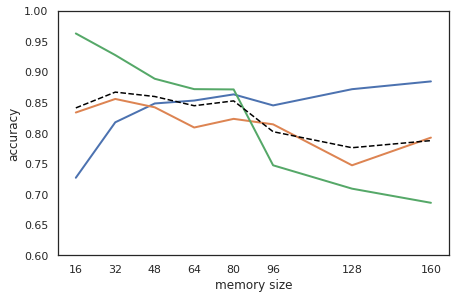

In [309]:
plt.figure(figsize=(7, 4.5))
sns.set_style('white')
plt.plot(cachesizes, [np.mean(accuracies[c]['LR']) for c in cachesizes], linewidth=2)
plt.plot(cachesizes, [np.mean(accuracies[c]['HR']) for c in cachesizes], linewidth=2)
plt.plot(cachesizes, [np.mean(accuracies[c]['HR TS']) for c in cachesizes], linewidth=2)
plt.plot(cachesizes, [np.mean([accuracies[c]['LR'], accuracies[c]['HR'], accuracies[c]['HR TS']]) for c in cachesizes], linewidth=1.5, linestyle='--', color='black')
plt.xticks(cachesizes)
plt.xlabel('memory size')
plt.ylabel('accuracy')
plt.ylim([0.60, 1.0])
plt.savefig(catutils.RESPATH+'memory_size_effect_accuracy.pdf')

In [313]:
[np.mean([accuracies[c]['LR'], accuracies[c]['HR'], accuracies[c]['HR TS']]) for c in cachesizes]

[0.841005622007574,
 0.8668418330747544,
 0.8596454131424853,
 0.8445702584121584,
 0.8524898653721035,
 0.8021378643044224,
 0.7759167042023256,
 0.7875506731394826]

In [312]:
[np.mean(accuracies[c]['HR']) for c in cachesizes]

[0.8334905660377359,
 0.8556603773584905,
 0.8419811320754718,
 0.8089622641509433,
 0.8231132075471699,
 0.8141509433962264,
 0.7471698113207547,
 0.7924528301886792]

In [317]:
df_ms = pd.DataFrame({'memorysize': cachesizes, 'task A': [np.mean(accuracies[c]['LR']) for c in cachesizes], 'task B': [np.mean(accuracies[c]['HR']) for c in cachesizes], 'task C': [np.mean(accuracies[c]['HR TS']) for c in cachesizes], 'mean acc': [np.mean([accuracies[c]['LR'], accuracies[c]['HR'], accuracies[c]['HR TS']]) for c in cachesizes]})

In [318]:
df_ms

,memorysize,task A,task B,task C,mean acc
0,16,0.726790,0.833491,0.962736,0.841006
1,32,0.817507,0.855660,0.927358,0.866842
2,48,0.848276,0.841981,0.888679,0.859645
3,64,0.853050,0.808962,0.871698,0.844570
4,80,0.863130,0.823113,0.871226,0.852490
5,96,0.845093,0.814151,0.747170,0.802138
6,128,0.871618,0.747170,0.708962,0.775917
7,160,0.884350,0.792453,0.685849,0.787551


In [320]:
df_ms.round(2).to_latex(catutils.RESPATH+'memory_size_effect.tex')

In [21]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dsts2_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'hr'
res[streamedDS.df.res == 'hr_ts'] = 2
newcmp = ListedColormap([sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]], name='OrangeBlue')

Load: /home/mperkonigg/zzz/__main__.res_data_for_params_cee5e3f299f69c0a5197608e6e1068d22f499d84.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_4f1753dd7e9c890be4a037aa3166e0ad4df68bd6.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_00d49c59e3e8ef04477454eb503742f8cf1a5e27.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_3ca5064e01b971f79169548951366679ff9e357f.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_3354d16c54f4c408dcb1fc74af7f21e9ddcc55ee.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_496f8e6bdae02cf7a39c80a61b65b39c9c6075be.p in: 0.00s


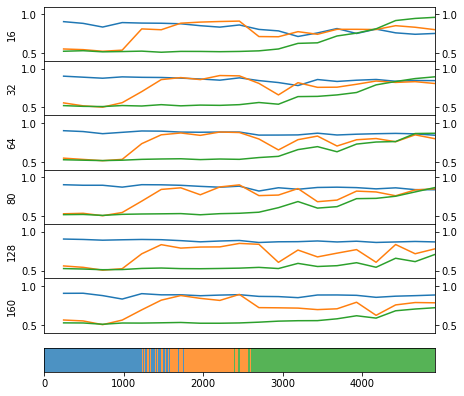

In [29]:
c_sizes = [16, 32, 48, 64, 80, 96, 128, 160]
c_sizes = [16, 32, 64, 80, 128, 160]
datas = ['catsinom_combined_dsts3_dataset.csv']
fig, ax = plt.subplots(7,1, figsize=(7, 7), frameon=False)
plt.subplots_adjust(hspace=0.0)
for j, c_size in enumerate(c_sizes):
    hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum': c_size,
            'force_misclassified':True}
    t_ews_res = cache.cache(res_data_for_params,hparams)

    axis = ax[j]
    sns.lineplot(data=t_ews_res, y='val_acc_lr', x='idx', ax=axis, err_style=None)
    sns.lineplot(data=t_ews_res, y='val_acc_hr', x='idx', ax=axis, err_style=None)
    sns.lineplot(data=t_ews_res, y='val_acc_hr_ts', x='idx', ax=axis, err_style=None)
    axis.get_xaxis().set_visible(False)
    axis.set_xlim(0, 20)
    axis.set_ylim(.4, 1.1)
    axis.set_ylabel('')
    axis.set_ylabel(r'%i' % c_size)
    axis.tick_params(labelright=True, right=True)
    axis.get_xaxis().set_visible(False)

ax[6].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[6].get_yaxis().set_visible(False)
ax[6].get_yaxis()
plt.savefig(catutils.RESPATH+ 'memory_size_effect_learning.pdf', bbox_inches='tight', pad_inches=0.1)